# Isentropic Analysis, Relative Humidity, and Winds

Classic isentropic level plot using GFS analysis file.

This example uses example data from the GFS analysis for 12 UTC
31 October 2016 and uses xarray as the main read source with using
MetPy to calculate the isentropic levels and wind speed with geographic
plotting using Cartopy for a CONUS view of the 300 K isentropic surface
with relative humidity, and wind barbs.

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

The following code reads the example data using the xarray open_dataset
function and prints the coordinate values that are associated with the
various variables contained within the file.

In [2]:
ds = xr.open_dataset('../../python_notebooks/data/GFS_20101026_1200.nc')
print(ds)

<xarray.Dataset>
Dimensions:                                  (height_above_ground: 1, height_above_ground1: 1, isobaric3: 26, isobaric5: 25, lat: 361, lon: 720, time: 1)
Coordinates:
  * time                                     (time) datetime64[ns] 2010-10-26T12:00:00
  * isobaric3                                (isobaric3) float32 1000.0 ... 100000.0
  * lat                                      (lat) float32 90.0 89.5 ... -90.0
  * lon                                      (lon) float32 0.0 0.5 ... 359.5
  * height_above_ground1                     (height_above_ground1) float32 10.0
  * isobaric5                                (isobaric5) float32 1000.0 ... 100000.0
  * height_above_ground                      (height_above_ground) float32 2.0
Data variables:
    u-component_of_wind_isobaric             (time, isobaric3, lat, lon) float32 ...
    v-component_of_wind_height_above_ground  (time, height_above_ground1, lat, lon) float32 ...
    v-component_of_wind_isobaric             (

## Data Retrieval

This code retrieves the necessary data from the file and completes some
smoothing of the geopotential height and wind fields using the SciPy
function gaussian_filter. A nicely formated valid time (vtime) variable
is also created.

In [3]:
# Grab lat/lon values (GFS will be 1D)
lat = ds.lat.data
lon = ds.lon.data

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(400,701)
lat_slice = slice(10,160)

# Subset lat/lon values
lons = lon[lon_slice]
lats = lat[lat_slice]

# Grab the pressure levels and select the data to be imported
# Need all pressure levels for Temperatures, U and V Wind, and Rel. Humidity
# Smooth with the gaussian filter from scipy
pres = ds['isobaric3'].data[:] * units('Pa')
tmpk_var = ds['Temperature_isobaric'].data[0, :, lat_slice, lon_slice]
tmpk = gaussian_filter(tmpk_var, sigma=1.0) * units.K
thta = mpcalc.potential_temperature(pres[:, None, None], tmpk)

uwnd_var = ds['u-component_of_wind_isobaric'].data[0, :, lat_slice, lon_slice]
vwnd_var = ds['v-component_of_wind_isobaric'].data[0, :, lat_slice, lon_slice]
uwnd = gaussian_filter(uwnd_var, sigma=1.0) * units('m/s')
vwnd = gaussian_filter(vwnd_var, sigma=1.0) * units('m/s')

relh_var = ds['Relative_humidity_isobaric'].data[0, :, lat_slice, lon_slice]
relh = gaussian_filter(relh_var, sigma=1.0) * units('percent')

# Need to do some work to add in missing pressure level for
# Relative Humidity Data - missing 2000 Pa level (index value 1 in tmpk array)
relh2 = np.empty(tmpk.shape)
missing_level = np.empty(relh.shape[1:])
missing_level.fill(np.nan)
relh2[0] = relh[0]
relh2[1] = missing_level
relh2[2:] = relh[1:]

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = ds.Geopotential_height_isobaric.time.values[0].astype('datetime64[ms]').astype('O')

Use MetPy to calcualte multiple isentropic levels from 280 - 300 K

In [4]:
isentlevs = list(range(280,331,2)) * units.K
print(isentlevs)
isent_anal = mpcalc.isentropic_interpolation(isentlevs,
                                             pres,
                                             tmpk,
                                             relh2,
                                             uwnd,
                                             vwnd)

# Isolate isentropic variables after interpolation convert winds to knots
isentprs, isentrelh, isentu, isentv = isent_anal
isentu.ito('kt')
isentv.ito('kt')

[280 282 284 286 288 290 292 294 296 298 300 302 304 306 308 310 312 314 316 318 320 322 324 326 328 330] kelvin


/Users/kgoebber/unidata_stuff/MetPy/src/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


In [5]:
# Determine the index value of 300 K
ilev = list(isentlevs.m).index(300)

## Map Creation

This next set of code creates the plot and draws contours on a Lambert Conformal
map centered on -100 E longitude. The main view is over the CONUS with
isentropic map with pressure contoured every 50 hPa and relative humidity
colorshaded above 70%.

/Users/kgoebber/miniconda3/envs/main/lib/python3.6/site-packages/cartopy/vector_transform.py:140: RuntimeWarning: invalid value encountered in less
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/Users/kgoebber/miniconda3/envs/main/lib/python3.6/site-packages/cartopy/vector_transform.py:140: RuntimeWarning: invalid value encountered in greater
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


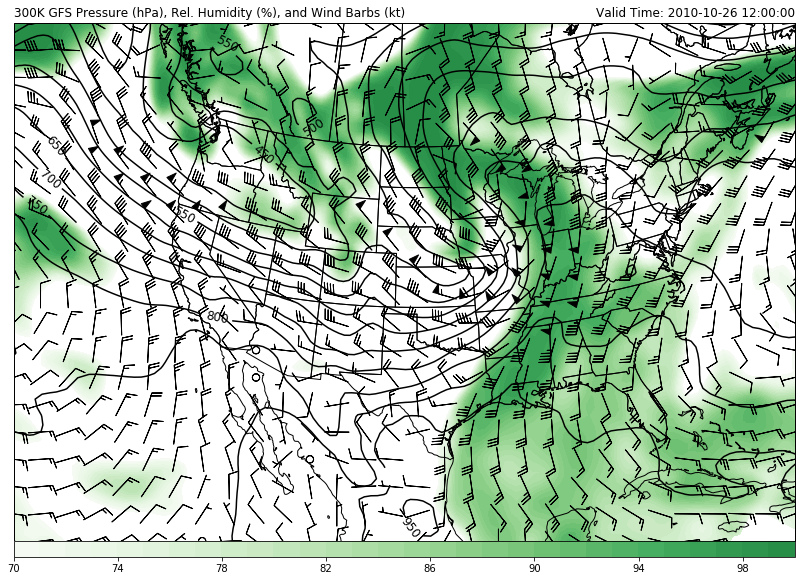

In [6]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14,12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot colorfilled RH >= 70%
clevs_relh = np.arange(70, 101, 1)
cf = ax.contourf(lons, lats, isentrelh[ilev], clevs_relh, cmap=plt.cm.Greens,
                 norm=plt.Normalize(70, 110), transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Plot isobars every 50 hPa
clevs_pres = np.arange(0, 1100, 50)
cs1 = ax.contour(lons, lats, mpcalc.smooth_n_point(isentprs[ilev], 9), clevs_pres, colors='black', transform=datacrs)
plt.clabel(cs1, fmt='%d', fontsize='large')

# Plot wind barbs
ax.barbs(lons, lats, isentu[ilev].m, isentv[ilev].m, pivot='middle',
         color='black', regrid_shape=20, transform=datacrs)

# Plot some nice titles on the left and right side of the top of the image
plt.title('{}K GFS Pressure (hPa), Rel. Humidity (%),'
          ' and Wind Barbs (kt)'.format(isentlevs[ilev].m), loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.savefig(f'{ilev}_K_Isentropic.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()